In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=2)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Sequential

import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch_geometric.transforms as T
import torch_cluster

from torch_geometric.nn import NNConv, GCNConv, GraphConv
from torch_geometric.nn import PointConv, EdgeConv, SplineConv

from sklearn.cluster import DBSCAN

In [2]:
torch.cuda.device_count()

In [3]:
#device = torch.device('cuda:0')
device = torch.device('cuda')

In [4]:
#!pip install --upgrade --force-reinstall torch-sparse && pip install --upgrade --force-reinstall torch-cluster && pip install --upgrade --force-reinstall torch-scatter && pip install --upgrade --force-reinstall torch-spline_conv && pip install --upgrade --force-reinstall torch-geometric

## Download train data

In [6]:
showers_train=torch.load('./data/showers_train.pt')

In [7]:
showers_train = [shower.to(device) for shower in showers_train[:20]]

## Features creation

In [8]:
for i in range(len(showers_train)):
    data = showers_train[i].x
    
    shape_0 = data.shape[0]
    
    #azimuthal_angle
    feat_0 = torch.atan(data[:, 1]/data[:, 0]).view(shape_0,1)
    
    feat_1 = (torch.sqrt(torch.pow(data[:, 1], 2) + torch.pow(data[:, 0],2))
              /data[:, 2]).view(shape_0,1)
    
    showers_train[i].x = torch.cat((data, feat_0, feat_1), 1)

In [9]:
showers_train[0].x.shape

torch.Size([8816, 7])

## Checking weather edges connect hits from the same shower

We need to compare Z-coordinates of each brick layer with our data Z-coordinate

In [10]:
Z = np.array([     0.,   1293.,   2586.,   3879.,   5172.,   6465.,   7758.,
                          9051.,  10344.,  11637.,  12930.,  14223.,  15516.,  16809.,
                         18102.,  19395.,  20688.,  21981.,  23274.,  24567.,  25860.,
                         27153.,  28446.,  29739.,  31032.,  32325.,  33618.,  34911.,
                         36204.,  37497.,  38790.,  40083.,  41376.,  42669.,  43962.,
                         45255.,  46548.,  47841.,  49134.,  50427.,  51720.,  53013.,
                         54306.,  55599.,  56892.,  58185.,  59478.,  60771.,  62064.,
                         63357.,  64650.,  65943.,  67236.,  68529.,  69822.,  71115.,
                         72408.,  73701.])

In [11]:
Z_centered = Z - 73701. / 2

In [12]:
Z_centered

array([-36850.5, -35557.5, -34264.5, -32971.5, -31678.5, -30385.5,
       -29092.5, -27799.5, -26506.5, -25213.5, -23920.5, -22627.5,
       -21334.5, -20041.5, -18748.5, -17455.5, -16162.5, -14869.5,
       -13576.5, -12283.5, -10990.5,  -9697.5,  -8404.5,  -7111.5,
        -5818.5,  -4525.5,  -3232.5,  -1939.5,   -646.5,    646.5,
         1939.5,   3232.5,   4525.5,   5818.5,   7111.5,   8404.5,
         9697.5,  10990.5,  12283.5,  13576.5,  14869.5,  16162.5,
        17455.5,  18748.5,  20041.5,  21334.5,  22627.5,  23920.5,
        25213.5,  26506.5,  27799.5,  29092.5,  30385.5,  31678.5,
        32971.5,  34264.5,  35557.5,  36850.5])

In [13]:
Z_0 = np.array(showers_train[0].x[:, 2].cpu())*np.array([1e4])

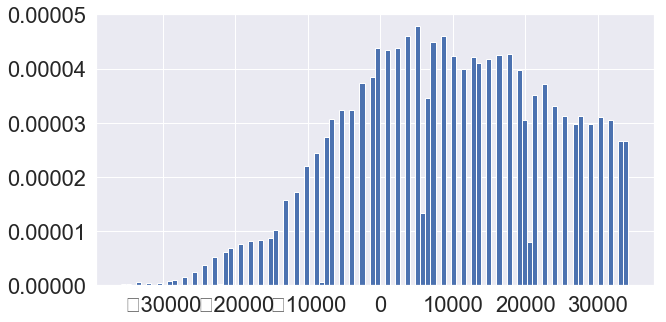

In [14]:
plt.figure(figsize=(10, 5))
# the histogram of the data
plt.hist(Z_0, 100, density=True)

plt.grid(True)
plt.show()


## Masks for activating only those edges that are connecting the same shower

In [15]:
def round_Z_coodr(x):
        return Z_centered[np.argmin(np.abs(Z_centered - x))]
round_Z_coodr = np.vectorize(round_Z_coodr)
    
def mask(data):
    x = data.x[:, 2]
    
    Z_0 = np.array(x.cpu())*np.array([1e4])
    
    z_rounded = round_Z_coodr(Z_0)
    
    orders = np.zeros((len(Z_centered), len(z_rounded)))

    for i, z_i in enumerate(Z_centered):
        for j, z_0_i in enumerate(z_rounded):
            orders[i][j] = int(z_0_i == z_i)
            
    return orders

In [16]:
masks = []
for i in range(len(showers_train)):
    masks.append(mask(showers_train[i]))

In [17]:
len(masks)

3

## GNN 

In [120]:
class EmulsionConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.mp = torch.nn.Linear(in_channels * 2, out_channels)
        
    def forward(self, x, edge_index, orders):
        for order in orders: 
            x = self.propagate('add', 
                               torch.index_select(edge_index[:, order], 0, torch.LongTensor([1, 0]).to('cuda')), x=x)     
        return x

    def message(self, x_j, x_i):
        return self.mp(torch.cat([x_i, x_j - x_i], dim=1))

    def update(self, aggr_out, x):
        return aggr_out + x

In [121]:
class GraphNN_KNN(torch.nn.Module):
    def __init__(self, k=7, dim_out=10):
        super().__init__()
        self.k = k
        self.emconv = EmulsionConv(self.k, dim_out)
        
        
    def forward(self, data, mask):
        x, edge_index, orders = data.x, data.edge_index, mask
        x = self.emconv(x=x, edge_index=edge_index, orders=orders)
        return x

In [122]:
showers_train[0].x.shape

torch.Size([8816, 7])

In [123]:
model = GraphNN_KNN(dim_out=7).to(device)

In [124]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [125]:
showers_train

[Data(edge_attr=[44065, 1], edge_index=[2, 44065], pos=[8816, 5], x=[8816, 7], y=[8816]),
 Data(edge_attr=[31765, 1], edge_index=[2, 31765], pos=[6356, 5], x=[6356, 7], y=[6356]),
 Data(edge_attr=[50505, 1], edge_index=[2, 50505], pos=[10104, 5], x=[10104, 7], y=[10104])]

----------------

In [126]:
embeddings = []

from tqdm import tqdm
for i in tqdm(range(3)):
    mask = masks[i % len(showers_train)]
    shower = showers_train[i % len(showers_train)]
    optimizer.zero_grad()
    embeddings.append(model(shower, mask))

100%|██████████| 3/3 [00:00<00:00, 18.03it/s]


In [127]:
embeddings

[tensor([[-0.7158,  0.7326, -1.4149,  ..., -0.0997, -0.7970, -0.7239],
         [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [-0.7131,  0.7200, -1.2875,  ..., -0.0965, -0.7902, -0.7870],
         ...,
         [-0.1940, -0.2138,  3.4226,  ..., -0.0835,  0.8339,  0.0843],
         [-0.1693,  0.8420,  3.4226,  ...,  0.2154, -1.3724,  0.2509],
         [-0.4229,  0.8779,  3.4226,  ..., -0.0833, -1.1219,  0.2847]],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[-0.4929, -0.8414, -1.1604,  ..., -0.0467,  1.0408, -0.8403],
         [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
         [-0.4727, -0.8528, -0.9057,  ..., -0.0497,  1.0647, -1.0766],
         ...,
         [-0.5056, -0.5523,  3.4226,  ..., -0.2649,  0.8295,  0.2188],
         [-0.2451, -0.2469,  3.4226,  ..., -0.2312,  0.7890,  0.1017],
         [-0.3822,  0.5576,  3.4228,  ...,  0.2637, -0.9699,  0.1975]],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[ 6.2146e

In [128]:
predicted_labels = []

for embedding in embeddings:
    data = np.nan_to_num(embedding.cpu().detach().numpy())
    dbscan = DBSCAN()
    pred = dbscan.fit_predict(data)
    predicted_labels.append(pred)

In [129]:
for i in range(len(predicted_labels)):
    print(i, len(np.unique(predicted_labels[i])))


0 50
1 40
2 41


In [130]:
from sklearn import metrics

In [134]:
for i in range(len(predicted_labels)):
    
    print(i, metrics.normalized_mutual_info_score(showers_train[i].y.cpu().detach().numpy(), predicted_labels[i]))

0 0.2607371032155714
1 0.2566908115701198
2 0.46643524479400594


/root/miniconda/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [135]:
##need for further work on net architecture 

_________________